Loading T2 to get grid ...
Loaded T2_2000-03.nc (cached)
Computing microphysics totals ...
Loaded RAINNC_2000-03.nc (cached)
Loaded SNOWNC_2000-03.nc (cached)
Loaded HAILNC_2000-03.nc (cached)
Loaded GRAUPELNC_2000-03.nc (cached)
Loaded I_RAINNC_2000-03.nc (cached)
Computing linear PPM totals ...
Loaded T2_2000-03.nc (cached)
Loaded I_RAINNC_2000-03.nc (cached)
Loaded RAINNC_2000-03.nc (cached)
Computing sigmoidal PPM totals ...
Loaded T2_2000-03.nc (cached)
Loaded I_RAINNC_2000-03.nc (cached)
Loaded RAINNC_2000-03.nc (cached)


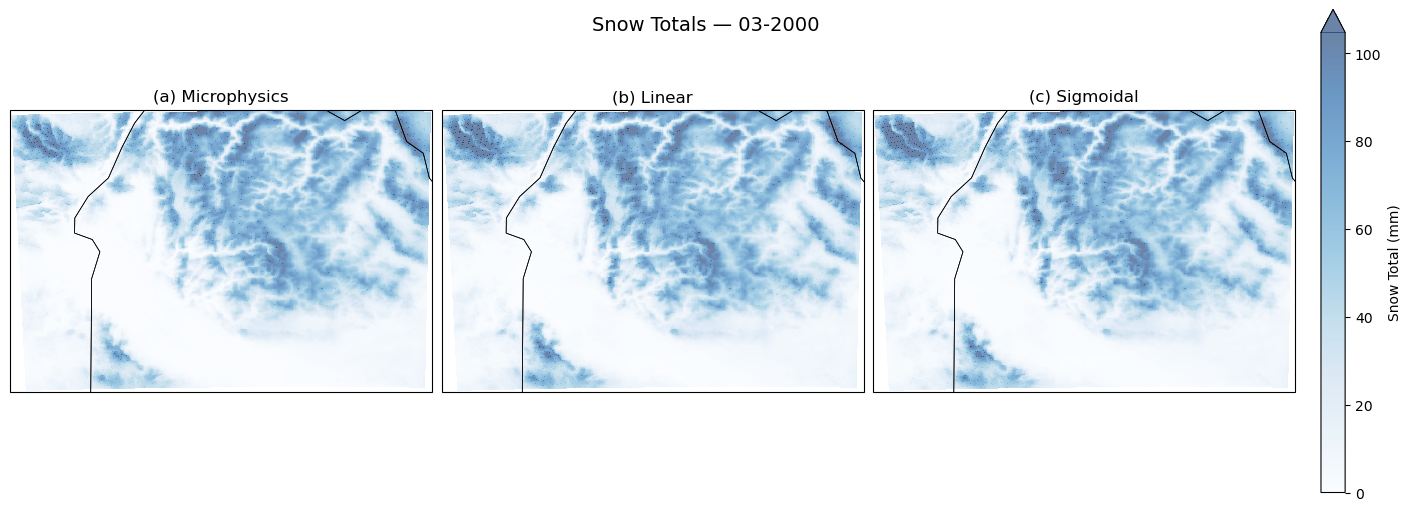

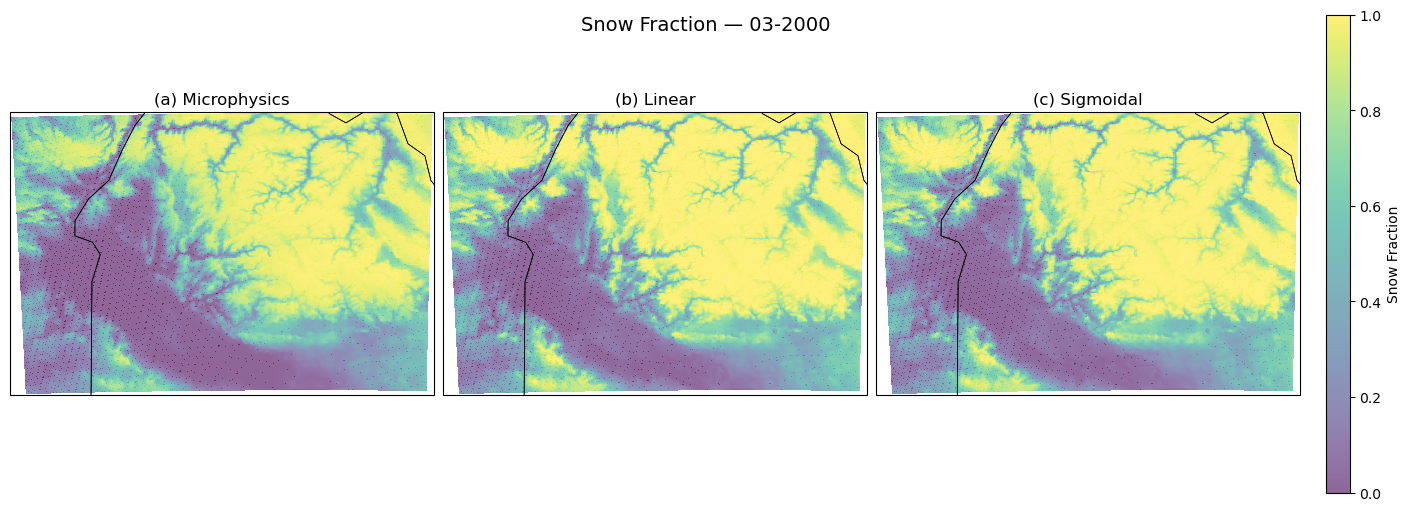

Linear: mean=0.090, median=0.075
Sigmoid: mean=0.089, median=0.073


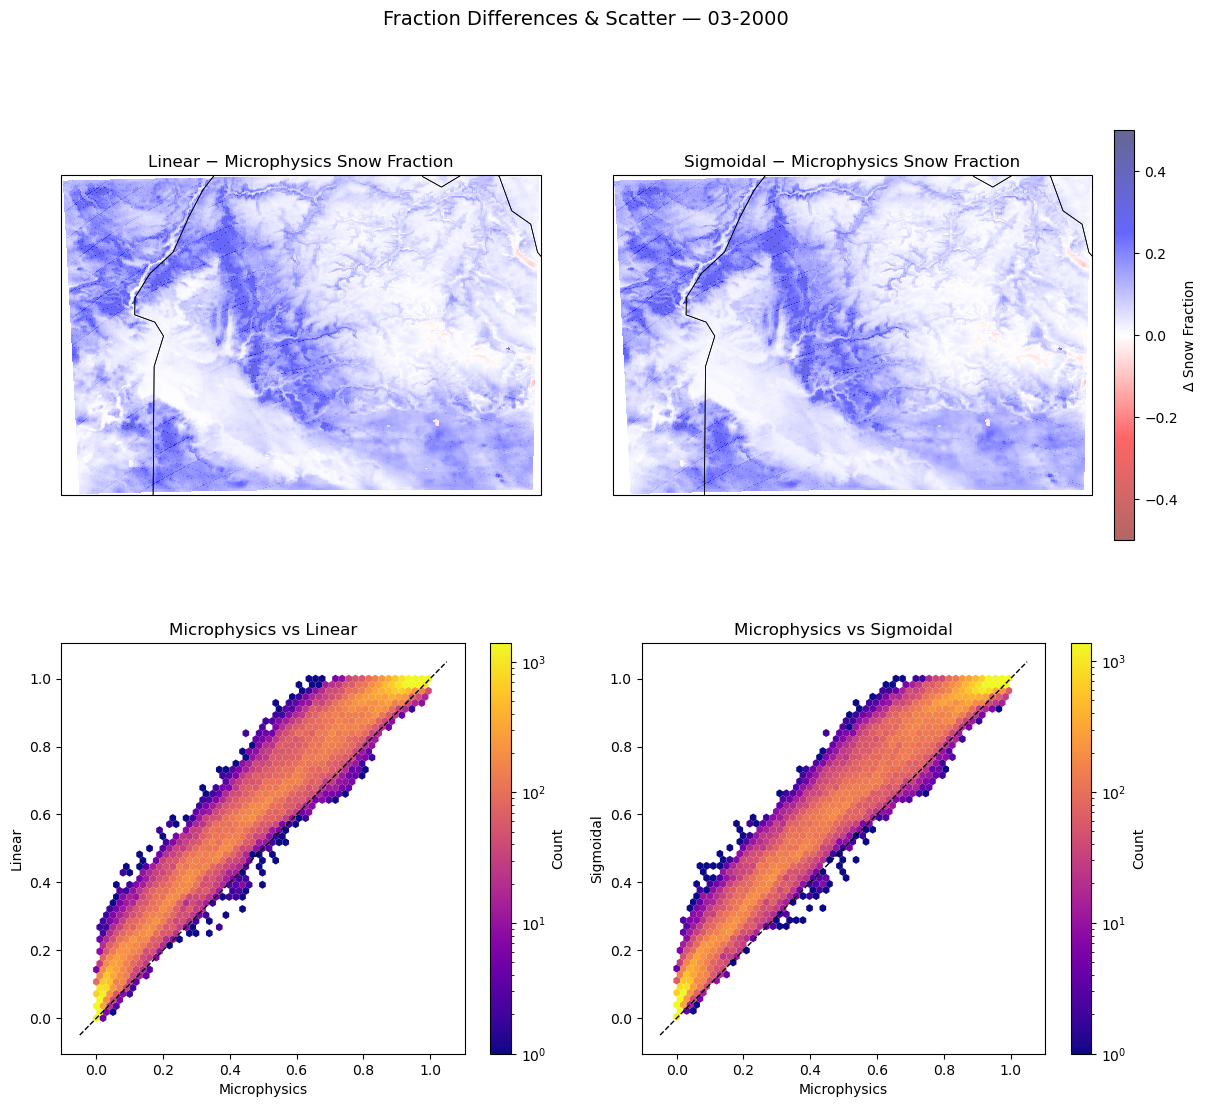

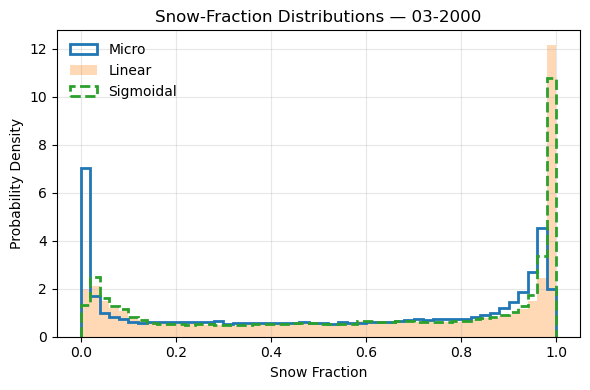

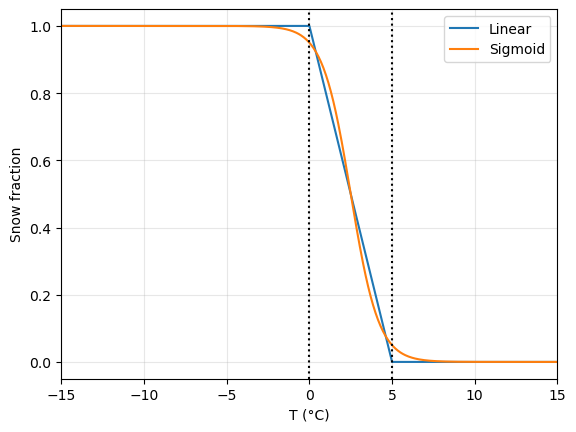

Linear − Sigmoid  snow‑fraction stats
  mean   = 0.0002
  median = 0.0012
  std    = 0.0075
  min/max= -0.0350 / 0.0325


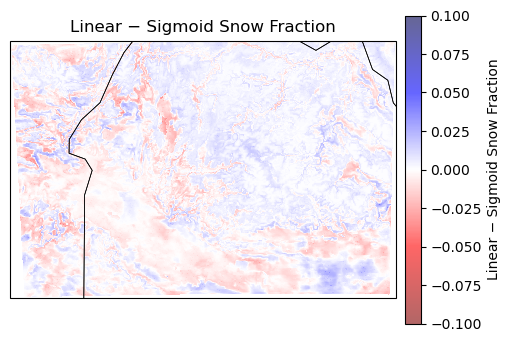

Loaded T2_2000-03.nc (cached)
Loaded I_RAINNC_2000-03.nc (cached)
Loaded RAINNC_2000-03.nc (cached)
Precip in 0–5 °C band: 32.1%


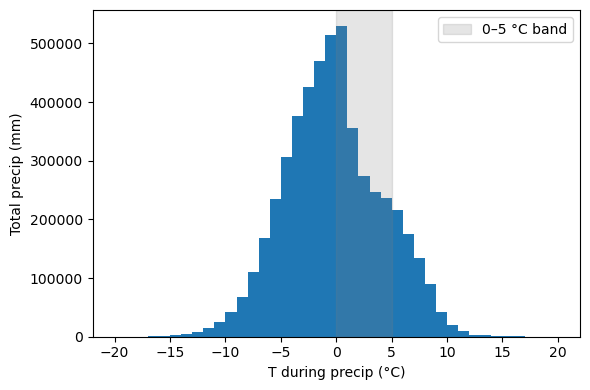

In [19]:
# -----------------------------------------------------------------------------
# compare_03_2000_driver.py — Driver / notebook cell
# -----------------------------------------------------------------------------
# * Load March 2000 WRF fields
# * Compute snow fraction via microphysics, linear, and sigmoidal schemes
# * Plot side-by-side maps and a multi-panel diagnostic figure
# -----------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from importlib import reload

import plot_utils; reload(plot_utils)
from plot_utils import (
    load_wrf_var,
    compute_microphysics_snow_frac,
    compute_linear_snow_frac,
    compute_sigmoidal_snow_frac,
    cartomap,
)

# ==========================
# CONFIG
# ==========================
D02_DIR = "/bsushare/leaf-shared/subset-output-wrf/vol04/wrf_out/wy_2000/d02/"
YEAR, MONTH = "2000", "03"
EPSILON = 1e-6

# Masks
MIN_PRECIP_MONTH = 1.0   # mm for monthly fields
MIN_PRECIP_HR    = 0.1   # mm/hr for hourly filter in linear/sigmoid paths

# Linear thresholds
T_SNOW_LINEAR = 0.0
T_RAIN_LINEAR = 5.0

# Sigmoidal anchors
T_SNOW_SIG    = 0.0
T_RAIN_SIG    = 5.0
F_SNOW_TARGET = 0.95
F_RAIN_TARGET = 0.05

# Colormaps
CMAP_MAP  = "Blues"       # totals
CMAP_FRAC = "viridis"     # 0–1 fraction
CMAP_DIFF = "seismic_r"   # differences
CMAP_HEX  = "plasma"

# Fixed limits
FRAC_MIN, FRAC_MAX = 0.0, 1.0
DIFF_MIN, DIFF_MAX = -0.5, 0.5
SNOW_MIN           = 0.0   # SNOW_MAX will be set from data

# Hexbin
HEX_GRIDSIZE = 50
HEX_TRIM_PCT = 99.0

# ==========================
# LOAD GRID
# ==========================
print("Loading T2 to get grid ...")
t2_ds = load_wrf_var("T2", D02_DIR, YEAR, MONTH)
lons = t2_ds["XLONG"][0].values
lats = t2_ds["XLAT"][0].values

# ==========================
# COMPUTE FIELDS
# ==========================
print("Computing microphysics totals ...")
precip_micro, snow_micro, liquid_micro, frac_micro = compute_microphysics_snow_frac(
    D02_DIR, YEAR, MONTH,
    min_precip_month=MIN_PRECIP_MONTH,
    epsilon=EPSILON
)

print("Computing linear PPM totals ...")
precip_lin, snow_lin, liquid_lin, frac_lin = compute_linear_snow_frac(
    D02_DIR, YEAR, MONTH,
    min_precip_hr=MIN_PRECIP_HR,
    TSNOW_THRESHOLD=T_SNOW_LINEAR,
    TRAIN_THRESHOLD=T_RAIN_LINEAR,
    epsilon=EPSILON,
    min_precip_month=MIN_PRECIP_MONTH
)

print("Computing sigmoidal PPM totals ...")
precip_sig, snow_sig, liquid_sig, frac_sig = compute_sigmoidal_snow_frac(
    D02_DIR, YEAR, MONTH,
    min_precip_hr=MIN_PRECIP_HR,
    T_snow=T_SNOW_SIG,
    T_rain=T_RAIN_SIG,
    F_snow=F_SNOW_TARGET,
    F_rain=F_RAIN_TARGET,
    epsilon=EPSILON,
    min_precip_month=MIN_PRECIP_MONTH
)

# ==========================
# SIDE-BY-SIDE SNOW TOTAL
# ==========================
SNOW_MAX = np.nanpercentile(
    np.concatenate([snow_micro.values.ravel(),
                    snow_lin.values.ravel(),
                    snow_sig.values.ravel()]),
    99.0
)

fig_tot, axs_tot = plt.subplots(
    1, 3, figsize=(14, 5),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=True
)

labels  = ['(a) Microphysics', '(b) Linear', '(c) Sigmoidal']
totals  = [snow_micro.values, snow_lin.values, snow_sig.values]
meshes  = []

for ax, data, lab in zip(axs_tot, totals, labels):
    m, _ = cartomap(ax, lons, lats, data, title=lab,
                    cmap=CMAP_MAP, vmin=SNOW_MIN, vmax=SNOW_MAX,
                    add_colorbar=False)
    meshes.append(m)

cbar = fig_tot.colorbar(meshes[0], ax=axs_tot,
                        orientation='vertical', fraction=0.03, pad=0.02,
                        extend='max')
cbar.set_label('Snow Total (mm)')
fig_tot.suptitle(f"Snow Totals — {MONTH}-{YEAR}", y=0.98, fontsize=14)
plt.show()

# ==========================
# SIDE-BY-SIDE SNOW FRACTION
# ==========================
fig_frac, axs_frac = plt.subplots(
    1, 3, figsize=(14, 5),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=True
)

labels    = ['(a) Microphysics', '(b) Linear', '(c) Sigmoidal']
fractions = [frac_micro.values, frac_lin.values, frac_sig.values]
meshes = []

for ax, data, lab in zip(axs_frac, fractions, labels):
    m, _ = cartomap(ax, lons, lats, data, title=lab,
                    cmap=CMAP_FRAC, vmin=FRAC_MIN, vmax=FRAC_MAX,
                    add_colorbar=False)
    meshes.append(m)

cbar = fig_frac.colorbar(meshes[0], ax=axs_frac,
                         orientation='vertical', fraction=0.03, pad=0.02)
cbar.set_label('Snow Fraction')
fig_frac.suptitle(f"Snow Fraction — {MONTH}-{YEAR}", y=0.98, fontsize=14)
plt.show()

# ==========================
# DIFF MAP COMPARISONS (2×2)
# Row 1: diff maps
# Row 2: corresponding hexbins
# ==========================
from matplotlib.colors import LogNorm as _LogNorm

fm = np.ma.masked_invalid(frac_micro.values)
fl = np.ma.masked_invalid(frac_lin.values)
fs = np.ma.masked_invalid(frac_sig.values)

diff_lin = fl - fm
diff_sig = fs - fm

for name, d in [('Linear', diff_lin), ('Sigmoid', diff_sig)]:
    arr = np.asarray(d).ravel()
    arr = arr[np.isfinite(arr)]
    print(f'{name}: mean={arr.mean():.3f}, median={np.median(arr):.3f}')
fig = plt.figure(figsize=(14, 12))
gs  = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.25, wspace=0.15)

# ---- Row 1: maps ----
ax_map_lin = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax_map_sig = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())

mesh_lin, _ = cartomap(ax_map_lin, lons, lats, diff_lin,
                       "Linear − Microphysics Snow Fraction",
                       cmap=CMAP_DIFF, vmin=DIFF_MIN, vmax=DIFF_MAX,
                       add_colorbar=False)

mesh_sig, _ = cartomap(ax_map_sig, lons, lats, diff_sig,
                       "Sigmoidal − Microphysics Snow Fraction",
                       cmap=CMAP_DIFF, vmin=DIFF_MIN, vmax=DIFF_MAX,
                       add_colorbar=False)

cbar_maps = fig.colorbar(mesh_lin, ax=[ax_map_lin, ax_map_sig],
                         orientation='vertical', fraction=0.03, pad=0.02)
cbar_maps.set_label('Δ Snow Fraction')

# ---- Hexbin helper ----
def hexbin_on_ax(ax, x, y, *,
                 gridsize=HEX_GRIDSIZE, cmap=CMAP_HEX,
                 log_counts=True, mincnt=1,
                 trim_zeros_ones=True, trim_pct=99.0,
                 xlabel="", ylabel="", title="", fig_for_cbar=None):
    xx = np.asarray(x); yy = np.asarray(y)
    good = np.isfinite(xx) & np.isfinite(yy)
    xx, yy = xx[good], yy[good]

    if trim_zeros_ones:
        edge = (np.isclose(xx, 0) | np.isclose(xx, 1) |
                np.isclose(yy, 0) | np.isclose(yy, 1))
        xx, yy = xx[~edge], yy[~edge]

    if log_counts:
        hb = ax.hexbin(xx, yy, gridsize=gridsize, cmap=cmap,
                       bins='log', mincnt=mincnt, edgecolors='none')
    else:
        norm = _LogNorm(vmin=max(mincnt, 1)) if log_counts else None
        hb = ax.hexbin(xx, yy, gridsize=gridsize, cmap=cmap,
                       edgecolors='none', norm=norm)

    if trim_pct is not None:
        arr = hb.get_array()
        if np.ma.isMaskedArray(arr):
            arr = arr.compressed()
        hb.set_clim(vmax=np.percentile(arr, trim_pct))

    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)

    if fig_for_cbar is not None:
        cb = fig_for_cbar.colorbar(hb, ax=ax)
        cb.set_label("Count")

    mn = min(ax.get_xlim()[0], ax.get_ylim()[0])
    mx = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([mn, mx], [mn, mx], 'k--', lw=1)

    return hb

# ---- Row 2: hexbins ----
ax_hex_lin = fig.add_subplot(gs[1, 0])
ax_hex_sig = fig.add_subplot(gs[1, 1])

hexbin_on_ax(ax_hex_lin,
             fm.compressed(), fl.compressed(),
             xlabel="Microphysics", ylabel="Linear",
             title="Microphysics vs Linear", fig_for_cbar=fig)

hexbin_on_ax(ax_hex_sig,
             fm.compressed(), fs.compressed(),
             xlabel="Microphysics", ylabel="Sigmoidal",
             title="Microphysics vs Sigmoidal", fig_for_cbar=fig)

fig.suptitle(f"Fraction Differences & Scatter — {MONTH}-{YEAR}", y=0.98, fontsize=14)
plt.show()

# ==========================
# Stand‑alone histogram of snow fraction
# ==========================
fig_hist, axh = plt.subplots(figsize=(6, 4))

bins = np.linspace(0, 1, 51)

axh.hist(fm.compressed(), bins=bins, density=True,
         histtype="step", linewidth=2, label="Micro")
axh.hist(fl.compressed(), bins=bins, density=True,
         histtype="stepfilled", alpha=0.3, label="Linear")
axh.hist(fs.compressed(), bins=bins, density=True,
         histtype="step", linestyle="--", linewidth=2, label="Sigmoidal")

axh.set_xlabel("Snow Fraction")
axh.set_ylabel("Probability Density")
axh.set_title(f"Snow‑Fraction Distributions — {MONTH}-{YEAR}")
axh.legend(frameon=False)
axh.grid(alpha=0.3)

plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from plot_utils import snow_frac_sigmoid

Tc = np.linspace(-15, 15, 601)

# Your linear curve
flin = np.clip((T_RAIN_LINEAR - Tc) / (T_RAIN_LINEAR - T_SNOW_LINEAR), 0, 1)

# Your sigmoid curve (same anchors you used above)
fsig = snow_frac_sigmoid(Tc, T_snow=T_SNOW_SIG, T_rain=T_RAIN_SIG,
                         F_snow=F_SNOW_TARGET, F_rain=F_RAIN_TARGET)

plt.plot(Tc, flin, label='Linear')
plt.plot(Tc, fsig, label='Sigmoid')
plt.axvline(T_SNOW_LINEAR, ls=':', c='k')
plt.axvline(T_RAIN_LINEAR, ls=':', c='k')
plt.xlim(-15, 15); plt.ylim(-0.05, 1.05)
plt.xlabel('T (°C)'); plt.ylabel('Snow fraction')
plt.legend(); plt.grid(alpha=.3)
plt.show()

# Linear – Sigmoid difference
diff_ls = frac_lin.values - frac_sig.values
mask    = np.isfinite(diff_ls)

print("Linear − Sigmoid  snow‑fraction stats")
print(f"  mean   = {diff_ls[mask].mean():.4f}")
print(f"  median = {np.median(diff_ls[mask]):.4f}")
print(f"  std    = {diff_ls[mask].std():.4f}")
print(f"  min/max= {diff_ls[mask].min():.4f} / {diff_ls[mask].max():.4f}")

# Quick map just to see pattern
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(6,4))
cartomap(ax, lons, lats, diff_ls, "Linear − Sigmoid Snow Fraction",
         cmap="seismic_r", vmin=-0.1, vmax=0.1)
plt.show()

# --- Grab hourly precip and temps again (or reuse if still in memory)
ds_t2   = load_wrf_var("T2", D02_DIR, YEAR, MONTH)
ds_cnt  = load_wrf_var("I_RAINNC", D02_DIR, YEAR, MONTH)
ds_rain = load_wrf_var("RAINNC",   D02_DIR, YEAR, MONTH)

precip_hr = plot_utils._hourly_precip(ds_cnt, ds_rain, MIN_PRECIP_HR)  # mm/hr
Tc_hr     = (ds_t2["T2"] - 273.15)                                     # °C

# Only hours/cells with precip
mask_p   = precip_hr > 0
temps_p  = Tc_hr.where(mask_p).values.ravel()
precip_w = precip_hr.where(mask_p).values.ravel()

good = np.isfinite(temps_p) & np.isfinite(precip_w)
temps_p, precip_w = temps_p[good], precip_w[good]

# Percentage of precip in transition band
band = (temps_p >= T_SNOW_LINEAR) & (temps_p <= T_RAIN_LINEAR)
pct_in_band = 100 * precip_w[band].sum() / precip_w.sum()
print(f"Precip in 0–5 °C band: {pct_in_band:.1f}%")

# Optional: precip-weighted histogram
bins = np.arange(-20, 21, 1)
hist, edges = np.histogram(temps_p, bins=bins, weights=precip_w)
cent = 0.5*(edges[:-1] + edges[1:])

plt.figure(figsize=(6,4))
plt.bar(cent, hist, width=1, align='center')
plt.axvspan(T_SNOW_LINEAR, T_RAIN_LINEAR, color='grey', alpha=.2, label='0–5 °C band')
plt.xlabel('T during precip (°C)'); plt.ylabel('Total precip (mm)')
plt.legend(); plt.tight_layout(); plt.show()
